# Project: Time Series Analysis
## by: Dhanush Kobal

- The prupose of this project is to show case various models and to also deploy the model using streamlit.
- The dashboard is very interactive 

- This dataset was downloaded from kaggle
    - https://www.kaggle.com/c/store-sales-time-series-forecasting/data

- ***Evaluation metric: MSE***

<br> The goal of this project is to predict ***sales*** for a particular store located in Ecuador</br>
Note: I will not be using stophactised models in this analysis. Just a simple analysis to showcase the model deployment of the ***data ecosystem***

In [1]:
# loading up the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import pmdarima as pm
import matplotlib.pyplot as plt 
from datetime import date
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf

data = pd.read_csv("train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


## 1) Aggregating data

- We will aggregate the data by ***date*** for ease of analysis

Result: We see that there are certain dips that happen periodically

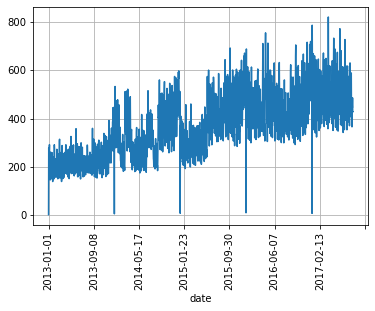

In [2]:
# We see that there is a dip that occurs seasonally

data = data.groupby('date').mean()
data.sales.plot(kind = 'line')
plt.grid()
plt.xticks(rotation=90)
plt.show()

## 2) ACF Analysis

Summary: 
- The ACF is decaying slowly, and we see that there are seasonal recurrency
- The TS is stationary at ***1st difference***, but the outliers produced a ***non-constant variance*** effect 
- We can't conclude to any model based on the ACF plot

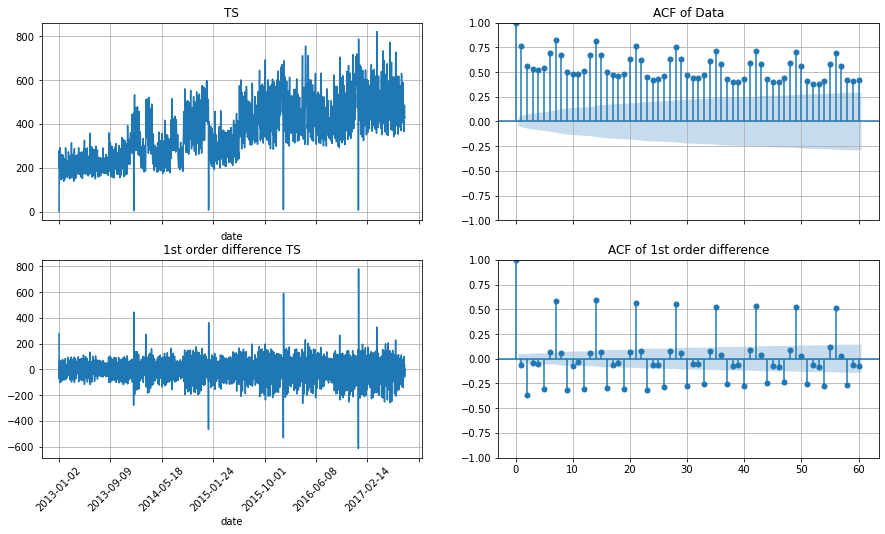

In [3]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,8))
frame1 = plt.gca()

data.sales.plot(kind = 'line', ax = ax1, title = 'TS')
plot_acf(data.sales, ax = ax2, lags = 60, title = 'ACF of Data')

data.sales.diff().dropna().plot(kind= 'line' , ax = ax3, title = '1st order difference TS')
plot_acf(data.sales.diff().dropna(), ax = ax4, lags = 60, title = 'ACF of 1st order difference')

ax1.grid();ax2.grid()
ax3.grid();ax4.grid()


ax1.xaxis.set_ticklabels([])
ax2.xaxis.set_ticklabels([])
ax3.tick_params('x', labelrotation=45)

plt.show()

# PACF Analysis

Summary:
- The P-ACF plots tail off
- We can't conclude to any model based on the P-ACF plot

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


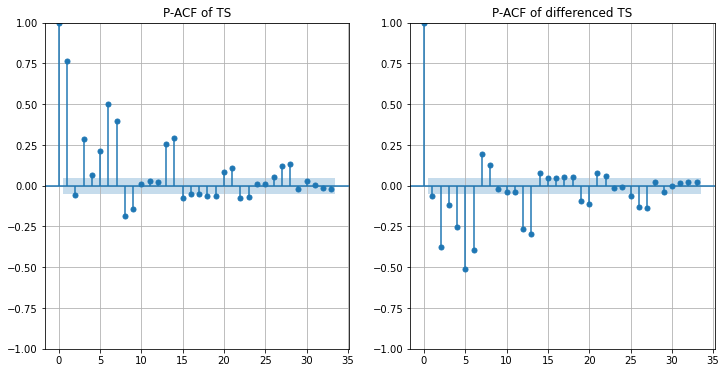

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plot_pacf(data.sales, ax = ax1, title = 'P-ACF of TS')
plot_pacf(data.sales.diff().dropna(), ax = ax2, title = 'P-ACF of differenced TS')

ax1.grid()
ax2.grid()

# TS decomposing

- There is an increasing trend
- Seasonality is present
- There are outliers that needs to be inspected
- The TS is ***weakly-stationary***

In [5]:
# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as ticker

result = seasonal_decompose(data['sales'], model='additive', period = 7)


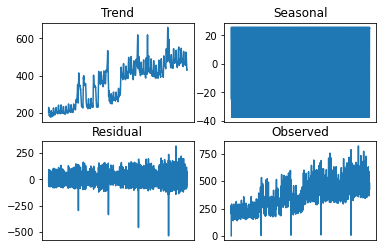

In [6]:
fig, axs = plt.subplots(2, 2)

# ax = plt.gca()
axs[0,0].plot(result.trend)
axs[0,0].get_xaxis().set_visible(False)
axs[0,0].set_title("Trend")

axs[0,1].plot(result.seasonal)
axs[0,1].get_xaxis().set_visible(False)
axs[0,1].set_title("Seasonal")

axs[1,0].plot(result.resid)
axs[1,0].get_xaxis().set_visible(False)
axs[1,0].set_title("Residual")

axs[1,1].plot(result.observed)
axs[1,1].get_xaxis().set_visible(False)
axs[1,1].set_title("Observed")

plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

# ADF test to see if that TS is stationary or not

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    

print(adf_test(data['sales']))  

Results of Dickey-Fuller Test:
Test Statistic                   -2.616196
p-value                           0.089696
#Lags Used                       22.000000
Number of Observations Used    1661.000000
Critical Value (1%)              -3.434293
Critical Value (5%)              -2.863282
Critical Value (10%)             -2.567697
dtype: float64
None


In [8]:
data['date'] = data.index

data['date'] = pd.to_datetime(data['date'])
data['month'] = [x.month for x in data.date]
data['day'] = [x.day for x in data.date]
data['year'] = [x.year for x in data.date]

In [9]:
# creating our CV folds

def ts_folds():
    meta = []
    dates = ['2016-01-01' ,'2016-06-01', '2017-01-01', '2017-08-15']
    j = 0
    for j in range(3):
        train_index = np.where(data.index <= dates[j])
        test_index = np.where((data.index > dates[j]) & (data.index <= dates[j+1]) )
        meta.append(train_index)
        meta.append(test_index)
    return meta


In [10]:
data.index = pd.to_datetime(data.index)
data.index = data.index.to_period('D')

# Modelling

## 1) Auto-SARIMA

- We have 3 folds that we will test on

In [12]:
import pmdarima as pm
from sklearn.metrics import r2_score
import statsmodels.api as sm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.preprocessing import LogEndogTransformer
from pmdarima import arima
from sklearn.preprocessing import StandardScaler

meta = []
for i in range(0,6,2):
    
    train = data.iloc[ts_folds()[i]].sales
    forecast = data.iloc[ts_folds()[i+1]].shape[0]
    test = data.iloc[ts_folds()[i+1]].sales

    pipeline = Pipeline([
        ('boxcox' , BoxCoxEndogTransformer()), # box-cox transform
        ('log', LogEndogTransformer()), # log transform
        ('model' , arima.AutoARIMA(error_action='ignore', seasonal=True,
                                  suppress_warnings=True, m = 1))
    ])
    
    pipeline.fit(train)
    pred = pipeline.predict(forecast)
    meta.append(r2_score(test, pred))
    print('R^2: ',r2_score(test, pred))
        

R^2:  -6.540613554476634
R^2:  0.3156516627496633
R^2:  -0.2890634665388867


Avg CV: -2.17


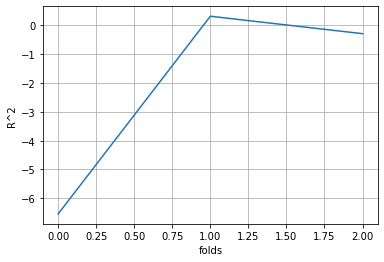

In [13]:
pd.Series(meta).plot()
plt.xlabel('folds')
plt.ylabel("R^2")
plt.grid()
print("Avg CV: {:.2f}".format(pd.Series(meta).mean()))

# 2) FaceBook Prophet Model

- The Prophet Model fails to capture the trend

In [14]:
from fbprophet import Prophet

meta = []

for i in range(0,6,2):
    train = data.iloc[ts_folds()[i]].sales
    forecast = data.iloc[ts_folds()[i+1]].shape[0]
    test = data.iloc[ts_folds()[i+1]].sales
    
    train = train.reset_index(drop=False)
    test = test.reset_index(drop=False)
    
    train.columns = ['ds', 'y']
    test.columns = ['ds', 'y']

    train.ds = train.ds.dt.to_timestamp()
    test.ds = test.ds.dt.to_timestamp()
    
    m = Prophet()
    m.fit(train)
    
    future = m.make_future_dataframe(periods= forecast)
    forecast_1 = m.predict(future)

    a = np.where(forecast_1.ds>= test.ds[0])
    meta.append(r2_score(test.y, forecast_1.iloc[a]['yhat']))
    print('R^2 score: ' , r2_score(test.y, forecast_1.iloc[a]['yhat']))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -117.248
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2170.16   0.000461651       59.9782      0.5564      0.5564      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       2172.12   0.000564152        153.45   6.301e-06       0.001      275  LS failed, Hessian reset 
     199       2172.13   0.000186187       75.6259           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       2172.16    2.3153e-05       75.6575   3.646e-07       0.001      349  LS failed, Hessian reset 
     284       2172.45   0.000805274       87.3412   1.008e-05       0.001      451  LS failed, Hessian reset 
     299       2172.51   3.75535e-05       68.7803      0.5839      0.5839      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


R^2 score:  0.4986818686663159
Initial log joint probability = -22.1271
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2549.59    0.00165333         84.57      0.3345           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2552.05   0.000206794       69.8472      0.7131      0.7131      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2552.69   0.000436326       72.0912      0.1063           1      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       2552.69   7.86254e-05       72.0977   1.104e-06       0.001      419  LS failed, Hessian reset 
     399       2552.82   5.00959e-07       62.6965           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


R^2 score:  -0.4778789612643952
Initial log joint probability = -164.707
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2914.05   0.000272278       71.6192     0.09683      0.3375      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       2915.34   0.000673325       153.826   1.066e-05       0.001      246  LS failed, Hessian reset 
     197       2915.46    5.7569e-05       67.0685    1.18e-06       0.001      347  LS failed, Hessian reset 
     199       2915.46   2.28548e-05       42.9495       1.394      0.3264      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       2915.46   2.14133e-07       48.6449           1           1      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
R^2 score:  0.28022648870608735


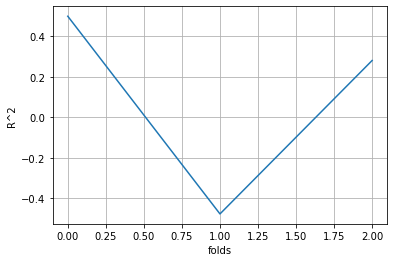

In [15]:
pd.Series(meta).plot()
plt.grid()
plt.xlabel('folds')
plt.ylabel('R^2')
plt.show()

# 3) Regression

In [16]:
# creating new features

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

data['quarter'] = data['date'].dt.quarter.astype(object)
data['date_of_week'] = data['date'].dt.dayofweek.astype(object)
data['date_of_week_name'] = data['date'].dt.day_name().astype(object)
data['is_weekend'] = np.where(data['date_of_week_name'].isin(['Sunday', 'Saturday']), 1, 0 ).astype(object)

data = data.drop('date', axis = 1)

In [17]:
from sklearn.compose import make_column_selector as selector

preprocessor = ColumnTransformer(
    transformers = [
        ('num' , StandardScaler(), selector(dtype_include= ['float64', 'int64'])),
        ('cat' , OneHotEncoder(handle_unknown='ignore') , selector(dtype_include= ['object']))
        ])


## - Feature importance

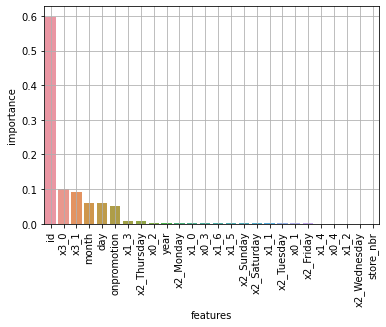

In [18]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=0)

pipeline = Pipeline(steps = [
    ('preprocessor' ,preprocessor),
    ('model' ,forest)
])

pipeline.fit(data.drop('sales', axis = 1) , data.sales)
pipeline.steps[1][1].feature_importances_

numeric_features = pipeline.named_steps['preprocessor'].transformers_[0][2]
cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names()

rf_features = numeric_features + cat_features.tolist()

feature_imp = pd.DataFrame({'features':rf_features , 'importance':pipeline.steps[1][1].feature_importances_.tolist() })

sns.barplot(data = feature_imp.sort_values(by = 'importance' , ascending= False),
            x = 'features', y = 'importance')
plt.xticks(rotation=90); plt.grid()


feature_importace = ['sales' ,'id', 'is_weekend', 'month', 'day' ,'onpromotion', 'date_of_week', 'year' , 'store_nbr']
plt.show()


### 1) Lasso Regression

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def predict_model(model, param_grid):
    
    meta = []
    pipeline = Pipeline(steps = [
        ('preprocessor' ,preprocessor),
        ('model' , model)
    ])

    
    gs = GridSearchCV(estimator = pipeline,
                 param_grid = param_grid,
                 cv = 3, scoring = 'r2' ,refit = True, n_jobs = -1)

    for  j in range(2 ,len(feature_importace)+1):
        train = data[feature_importace[0:j]].iloc[ts_folds()[4]]
        forecast = data.iloc[ts_folds()[4+1]].shape[0]
        test = data[feature_importace[0:j]].iloc[ts_folds()[4+1]]

        gs = gs.fit(train.drop(['sales'], axis = 1), train.sales)
        r2 = r2_score(test.sales ,gs.predict(test.drop(['sales'], axis = 1)))
        meta.append([train.columns[-1] , r2, gs.best_score_, gs.best_params_])
        
    return meta


from sklearn.model_selection import cross_val_score

def my_cv(model):
    meta = []
    
    for j in range(2 ,len(feature_importace)+1):
        train = data[feature_importace[0:j]].iloc[ts_folds()[4]]
        test = data[feature_importace[0:j]].iloc[ts_folds()[4+1]]
        scores = cross_val_score(model , train.drop('sales', axis = 1) , train.sales, cv = 3, 
                                scoring = 'neg_root_mean_squared_error')
        meta.append([train.columns[-1] , np.mean(-scores), np.mean(-scores) - np.std(-scores) ,np.mean(-scores) + np.std(-scores)])
    return meta

def plot_cv(model):
    a = pd.DataFrame(my_cv(model))
    a.columns = ['feature', 'mean', 'mean_minus_std', 'mean_plus_std']
    print(a)
    ax = sns.lineplot(data = a, markers = True,x = 'feature', y = 'mean')
    ax.fill_between(x = 'feature', y1 = 'mean_minus_std', y2 = 'mean_plus_std', data = a,
               facecolor = 'red', alpha = 0.5)

    plt.grid();plt.xticks(rotation=90);plt.show()

In [21]:
model = linear_model.Lasso(max_iter=10000)
param_grid = [{'model__alpha': [0.01,0.01, 0.1, 10, 100]}]
lasso_hyper_param = pd.DataFrame(predict_model(model, param_grid))
lasso_hyper_param.sort_values(2)

,0,1,2,3
0,id,-0.138012,0.080024,{'model__alpha': 0.01}
5,date_of_week,0.366444,0.237510,{'model__alpha': 10}
6,year,0.366444,0.237510,{'model__alpha': 10}
7,store_nbr,0.366444,0.237510,{'model__alpha': 10}
4,onpromotion,0.495134,0.263474,{'model__alpha': 0.1}
2,month,0.449222,0.306953,{'model__alpha': 0.1}
3,day,0.488818,0.325332,{'model__alpha': 0.1}
1,is_weekend,0.403544,0.407700,{'model__alpha': 0.01}


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2202301.7910142443, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2202301.7910142443, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(


        feature       mean  mean_minus_std  mean_plus_std
0            id  88.759164       72.465845     105.052482
1    is_weekend  71.254653       57.994750      84.514556
2         month  75.859605       69.878700      81.840511
3           day  74.814743       69.015672      80.613814
4   onpromotion  78.582053       67.971782      89.192325
5  date_of_week  82.246481       67.364040      97.128922
6          year  82.250018       67.369555      97.130480
7     store_nbr  82.250018       67.369555      97.130480


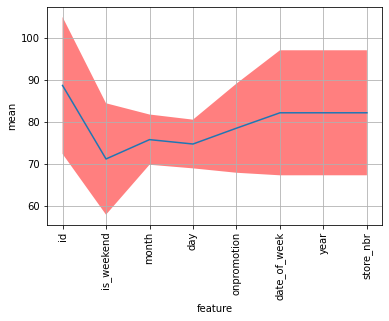

In [22]:
model = linear_model.Lasso(max_iter=10000, alpha = 0.01)
plot_cv(model)

### 2) Elastic Net

In [24]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(random_state=0,selection='random')
param_grid = [{'model__alpha': [0.01,0.01, 0.1, 10, 100],
              'model__l1_ratio': np.arange(0, 1, 0.01)}]

e_net_hyper_param = pd.DataFrame(predict_model(model, param_grid))
e_net_hyper_param.sort_values(2)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4852347.379409825, tolerance: 1278.2214162712523
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3822017.244719107, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3225219.6222887128, tolerance: 966.9531217412915
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6119233.645632159, tolerance: 1278.2214162712523
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4613104.936200673, tolerance: 966.9531217412915
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6361649.814072844, tolerance: 1278.2214162712523
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6051406.605964554, tolerance: 1278.2214162712523
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8317616.781617673, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4564497.006209387, tolerance: 966.9531217412915
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5402.304736617953, tolerance: 1278.2214162712523
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10257.786255960353, tolerance: 1278.2214162712523
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16943.278192763682, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceW

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6350019.735798891, tolerance: 1278.2214162712523
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9059527.688337514, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4802686.479211803, tolerance: 966.9531217412915
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 439220.8330351156, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97417.05980400741, tolerance: 1278.2214162712523
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266325.80110680475, tolerance: 966.9531217412915
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5965162.520510789, tolerance: 1278.2214162712523
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7946399.14007722, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4466959.5446806615, tolerance: 966.9531217412915
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1233693.8922661082, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 778642.5957458257, tolerance: 966.9531217412915
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 775870.6313319227, tolerance: 966.9531217412915
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarn

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 776934.8658283693, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 810583.7749105031, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 743112.2909358237, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 887792.3440493529, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1007663.6916404197, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 647234.2454305722, tolerance: 1278.2214162712523
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWa

,0,1,2,3
0,id,-0.137889,0.080010,"{'model__alpha': 0.01, 'model__l1_ratio': 0.99}"
4,onpromotion,0.478339,0.289589,"{'model__alpha': 0.1, 'model__l1_ratio': 0.19}"
5,date_of_week,0.529591,0.294007,"{'model__alpha': 0.1, 'model__l1_ratio': 0.0}"
6,year,0.519771,0.308384,"{'model__alpha': 0.1, 'model__l1_ratio': 0.0}"
7,store_nbr,0.519771,0.308384,"{'model__alpha': 0.1, 'model__l1_ratio': 0.0}"
2,month,0.440313,0.314447,"{'model__alpha': 0.1, 'model__l1_ratio': 0.54}"
3,day,0.480949,0.333492,"{'model__alpha': 0.1, 'model__l1_ratio': 0.55}"
1,is_weekend,0.404831,0.407724,"{'model__alpha': 0.01, 'model__l1_ratio': 0.82..."


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227864.348472269, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227864.348472269, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(


        feature       mean  mean_minus_std  mean_plus_std
0            id  88.759164       72.465845     105.052482
1    is_weekend  71.218952       57.809622      84.628282
2         month  75.837028       69.717336      81.956719
3           day  74.791696       68.851155      80.732237
4   onpromotion  78.366757       67.840847      88.892667
5  date_of_week  81.301233       67.216972      95.385495
6          year  81.301615       67.217551      95.385679
7     store_nbr  81.301615       67.217551      95.385679


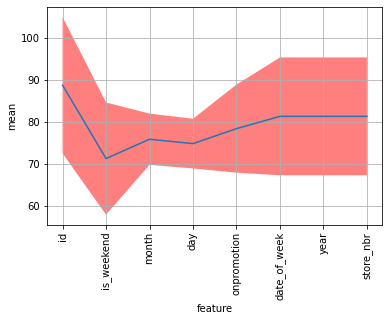

In [25]:
model = ElasticNet(random_state=0, alpha = 0.01, l1_ratio = 0.73)
plot_cv(model)

### 3) Ridge Regression

In [26]:
from sklearn.linear_model import Ridge
model = Ridge()
param_grid = [{'model__alpha': [0.01,0.01, 0.1, 10, 100]}]
ridge_hyper_param = pd.DataFrame(predict_model(model, param_grid))
ridge_hyper_param.sort_values(2)

,0,1,2,3
0,id,-0.138145,0.080049,{'model__alpha': 0.01}
4,onpromotion,0.483020,0.288392,{'model__alpha': 100}
5,date_of_week,0.541891,0.294238,{'model__alpha': 100}
6,year,0.532299,0.309056,{'model__alpha': 100}
7,store_nbr,0.532299,0.309056,{'model__alpha': 100}
2,month,0.449126,0.309918,{'model__alpha': 10}
3,day,0.488976,0.328436,{'model__alpha': 10}
1,is_weekend,0.403540,0.407707,{'model__alpha': 0.1}


        feature       mean  mean_minus_std  mean_plus_std
0            id  88.759164       72.465845     105.052482
1    is_weekend  71.253961       57.992749      84.515172
2         month  75.859176       69.877949      81.840403
3           day  74.814301       69.014890      80.613712
4   onpromotion  78.589515       67.967306      89.211725
5  date_of_week  82.248806       67.355262      97.142350
6          year  82.255212       67.349510      97.160913
7     store_nbr  82.255212       67.349510      97.160913


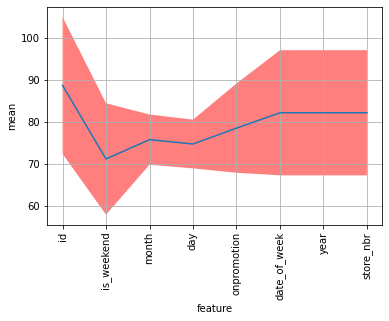

In [27]:
model = Ridge(alpha = 0.1)
plot_cv(model)

# Stacking 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1609463.6433107115, tolerance: 896.2322424261417
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1147459.3032257592, tolerance: 793.3917482335253
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2202301.7910142443, tolerance: 1831.9139166000039
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWa

        feature        mean  mean_minus_std  mean_plus_std
0            id  129.951752       99.427915     160.475589
1    is_weekend  130.329338      110.705443     149.953232
2         month  116.165685       69.160321     163.171050
3           day  112.888349       70.427517     155.349182
4   onpromotion   79.836457       72.154137      87.518777
5  date_of_week  118.102158       74.710084     161.494232
6          year   82.849943       78.158986      87.540900
7     store_nbr   82.849943       78.158986      87.540900


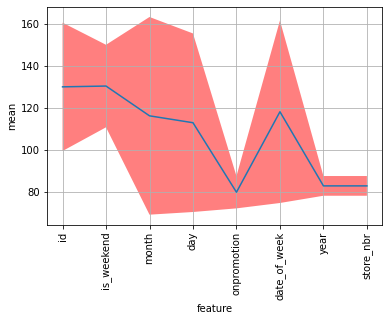

In [28]:
from sklearn.ensemble import StackingRegressor
def get_stacking():
    level0 = list()
    level0.append(('lasso', linear_model.Lasso(max_iter=10000, alpha = 0.01)))
    level0.append(('enet', ElasticNet(random_state=0, alpha = 0.01, l1_ratio = 0.73)))
    level0.append(('ridge', Ridge(alpha = 0.1)))
    level1 = LinearRegression()
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=3)
    return model

plot_cv(get_stacking())

- The lowest MSE results from our elastic net model, so we will use that as our final model
- Based on the feature engineering, the only thing we need is the "is_weekend" and "id" parameter

In [29]:
from sklearn.linear_model import ElasticNet
final_model_1 = ElasticNet(random_state=0, alpha = 0.01, l1_ratio = 0.73)
X = data[['id', 'is_weekend']]
y = data.sales


final_model = Pipeline(steps = [
        ('preprocessor' ,preprocessor),
        ('model' , final_model_1)
    ])

final_model.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x127ddc8e0>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x127ddc6d0>)])),
                ('model',
                 ElasticNet(alpha=0.01, l1_ratio=0.73, random_state=0))])

- Save the model for deployment

In [30]:
import joblib
joblib.dump(final_model,'e_net.pkl')

['e_net.pkl']